# Building an image classifier using the Sequential API for Tensorflow

## Getting started with Fashion MNIST

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import random

print(tf.__version__)

print(keras.__version__)

2.1.0
2.2.4-tf


In [2]:
#Building Image classifier using Sequential API

#Load the data from the keras datasets
fashion_mnist = keras.datasets.fashion_mnist

(X_train_full,y_train_full),(X_test,y_test) = fashion_mnist.load_data()

print(X_train_full.shape)
print(X_train_full.dtype)

print(X_test.shape)
print(X_test.dtype)

# # print("range(20) output: {}".format(range(20)))
# # print("np.arange(20) output: {}".format(np.arange(20)))

# a2 = np.arange(20)
# b = np.array(random.sample(range(20), 10))

# print(a2 ) 
# print(np.array_equal(a2 == b) 

# # print(type(np.array(b)))
# # print(type(a2))

# # print(a2)
# # print(b)
# # print(c)


(60000, 28, 28)
uint8
(10000, 28, 28)
uint8


In [3]:
# Create validation dataset

#Note, there is a way to specify the validation percent directly while compiling the model, but that takes only the last n% samples,
# and it seems that wont work if data is not shuffled

percent_samples = 20
total_samples = X_train_full.shape[0]

num_validation_samples = int(total_samples* percent_samples / 100)
print("Num validation samples to be used: {}".format(num_validation_samples))
print("Total number of samples : {}".format(total_samples))

#Get the shuffled indices 
a = np.arange(total_samples)
shuffled_idx = shuffle(a)

#Create the validation indices
idx_val = shuffled_idx[:num_validation_samples]

#Create the training indices
idx_train = shuffled_idx[num_validation_samples:]

#SLice the dataset
X_valid, X_train = X_train_full[idx_val] / 255.0, X_train_full[idx_train] / 255.0
y_valid, y_train = y_train_full[idx_val], y_train_full[idx_train]

# X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
# y_valid, y_train = y_train_full[:5000], y_train_full[5000:]


Num validation samples to be used: 12000
Total number of samples : 60000


In [4]:
#Specify the class names:
class_names = ["tshirt", "trouser", "Pullover","Dress","Coat","Sandat","Shirt","Sneaker","Bag","Ankle boot"]

#Print an example to see if the code works
print(class_names[y_train[0]])

Shirt


## Model creation and training

Showing images on grid of rows=2, and cols=5


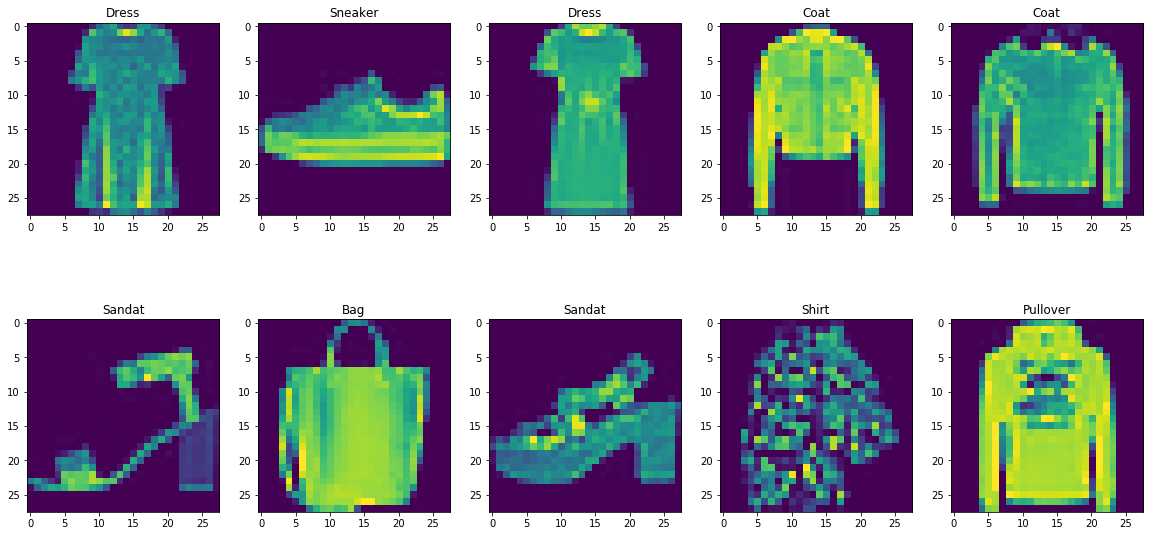

In [5]:
#Show some of the dataset
import random
num_show_samples = 10 
idx_show = random.sample(range(X_train.shape[0]),num_show_samples)
#print(idx_show)

# X_train[0]
# plt.subplot(2,2,1)
# plt.imshow(X_train[0])

rows = 2
cols = int(np.ceil(num_show_samples / rows))
print("Showing images on grid of rows={}, and cols={}".format(rows,cols))

plt.figure(figsize=(20,10))
for i in range(num_show_samples):
    ax =plt.subplot(rows,cols,i+1)
    ax.imshow(X_train[idx_show[i],:])
    plt.title("{}".format(class_names[y_train[idx_show[i]]]))
    

In [6]:
#Create the model using Sequential data API
# 1)
# model = keras.models.Sequential()
# model.add(keras.layers.Flatten(input_shape=[28,28]))
# model.add(keras.layers.Dense(300,activation="relu"))
# model.add(keras.layers.Dense(100,activation="relu"))
# model.add(keras.layers.Dense(10,activation="softmax"))

# 2)
# #OR create a model this way
# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=[28,28]),
#     keras.layers.Dense(300, activation="relu"),
#     keras.layers.Dense(100,activation="relu"),
#     keras.layers.Dense(10,activation="softmax")    
# ], name="mnist_mlp")

# 3) 
#Note, you can also specify the input layer as
#keras.layers.InputLayer(input_shape=[28,28]) 
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=[28,28]),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(10,activation="softmax")    
], name="mnist_mlp")


#Printing the model summary
model.summary()

# tf.keras.utils.plot_model(
#     model, to_file='../images/model.png', show_shapes=True, show_layer_names=True,
#     rankdir='TB', expand_nested=False, dpi=96
# )

#tf.keras.utils.plot_model(model, show_shapes=True)


Model: "mnist_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Print and access model layers
print("Model layers: {}".format(model.layers))

#Fetch by index
print("Layer idx 0: {}".format(model.layers[0]))
print("Layer idx 2: {}".format(model.layers[2]))

hidden1 = model.layers[1]
print(hidden1.name)

#Fetch by name
# temp_layer =  model.get_layer("dense_4")
# print(temp_layer.name)

#Access parameters of a given layer
weights,biases = hidden1.get_weights()
weights.shape


Model layers: [<tensorflow.python.keras.layers.core.Flatten object at 0x00000165DEC66A20>, <tensorflow.python.keras.layers.core.Dense object at 0x000001659EC97BA8>, <tensorflow.python.keras.layers.core.Dense object at 0x00000165D3605C18>, <tensorflow.python.keras.layers.core.Dense object at 0x00000165DEC543C8>]
Layer idx 0: <tensorflow.python.keras.layers.core.Flatten object at 0x00000165DEC66A20>
Layer idx 2: <tensorflow.python.keras.layers.core.Dense object at 0x00000165D3605C18>
dense


(784, 300)

In [8]:
#Compile the model

#Using sparse_categorical_crossentropy because the target values are just target class indices 0-9,
#not one hot encoded vectors. For one hot encoded y_train, use categorical_crossentropy
#For binary classification, use binary_crossentropy, but also change the activation of output layer to be 
# sigmoid instead of the softmax activation

#keras.utils.to_categorical()
#print(keras.utils.to_categorical(y_train))

model.compile(loss="sparse_categorical_crossentropy",
             optimizer = keras.optimizers.SGD(lr=0.2),
             metrics = ["accuracy"])

## Callbacks for the model 

In [9]:
# Use save Modelcheckpoint callback so that I have intermediate versions of the trained model before the training has completed.
    #Byt default, this saves model at end of each epoch, but callbacks can be called at 
    # start/end of epoch, start/end of each batch, start/end of training 

#Use EarlyStopping to reduce resource usage.

import os

model_folder_name = "mlp_basic"
model_name = model_folder_name + ".h5"


#ModelCheckpoint - Save only the best model
save_model_filepath = os.path.join(os.pardir,"models",model_folder_name,model_name)

print("ModelCheckpoint Callback saves the model in: {}".format(save_model_filepath))

checkpoint_cb = keras.callbacks.ModelCheckpoint(save_model_filepath,
                                               save_best_only=True)

# Early stopping.
# ModelCheckpoint will save best, but wont stop training, which might go on for a long time and consume resources.
# Early stoppoing callback helps with this
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                      patience=10,
#                                                      restore_best_weights=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

#Create a custom callback if needed. For example, display the ratio of validation loss / training_loss to detect overfitting
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        print("\n Custom Callback - Epoch: {}, val/train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))

#Instance of the custom callback
print_ratio_cb = PrintValTrainRatioCallback()


#Tensorboard callback

#Note:
#For windows, forward and back slahses are painful to get right for the tensorboard usage.
# What works is that create a windows path, and replace the \ with \\

#Save data in models folder.
root_logdir = os.path.join(os.pardir, "models", model_folder_name, "tensorboard", "my_logs")
print("Tensorboard parent logs folder: {}".format(root_logdir))

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)

run_logdir = get_run_logdir()
print("Current logdir: {}".format(run_logdir))

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
# tensorboard_cb = keras.callbacks.TensorBoard("C:/Users/abhat/research/Tensorflow_2.0_tutorials/models/mlp_basic/tensorboard/my_logs")

print("Note: Unable to get launch tensorboard with right directory from the notebook on Windows." 
      "Instead, just start tensorboard from the command line externally")

#Note: Unable to get launch tensorboard with right directory from the notebook on Windows. 
#Instead, just start tensorboard from the command line externally

# print("Launching Tensorboard for visualization...")
# %load_ext tensorboard
# %tensorboard --logdir=run_logdir --port=6006
# %tensorboard --logdir="C:\Users\abhat\research\Tensorflow_2.0_tutorials\models\mlp_basic\tensorboard\my_logs" --port=6006


ModelCheckpoint Callback saves the model in: ..\models\mlp_basic\mlp_basic.h5
Tensorboard parent logs folder: ..\models\mlp_basic\tensorboard\my_logs
Current logdir: ..\models\mlp_basic\tensorboard\my_logs\run_2020_03_01_15_17_47
Note: Unable to get launch tensorboard with right directory from the notebook on Windows.Instead, just start tensorboard from the command line externally


### Tensorboard debugging notes
#### 1) Replace the \ with /. Windows path works only if the path string has \\ (eg: source\\data) , not single backslash (eg: source\data), or if the unix style path is used

#### 2) Some cases tensorboard doesnt work. Error shows duplicate entries.
Following link helps in removing this error

https://github.com/pytorch/pytorch/issues/22676
Suggestion: Fix conflicting installations

Conflicting package installations found. Depending on the order of
installations and uninstallations, behavior may be undefined. Please
uninstall ALL versions of TensorFlow and TensorBoard, then reinstall
ONLY the desired version of TensorFlow, which will transitively pull
in the proper version of TensorBoard. (If you use TensorBoard without
TensorFlow, just reinstall the appropriate version of TensorBoard
directly.)

Namely:

	pip uninstall tb-nightly tensorboard tensorflow-estimator tensorflow-gpu tf-estimator-nightly
	pip install tensorflow  # or `tensorflow-gpu`, or `tf-nightly`, ...

In [10]:
#"!kill 15840"

In [11]:
#Launch tensorboard from the model

# %load_ext tensorboard
# %tensorboard --logdir=run_logdir --port=6006
#Train the model
history  = model.fit(X_train,y_train,epochs=100,
                     validation_data=(X_valid,y_valid),
                     callbacks=[checkpoint_cb, early_stopping_cb, print_ratio_cb, tensorboard_cb])



Train on 48000 samples, validate on 12000 samples
Epoch 1/100
47680/48000 [============================>.] - ETA: 0s - loss: 0.5574 - accuracy: 0.7949
 Custom Callback - Epoch: 0, val/train loss ratio: 0.91
48000/48000 [==============================] - 14s 289us/sample - loss: 0.5566 - accuracy: 0.7951 - val_loss: 0.5061 - val_accuracy: 0.8038
Epoch 2/100
47904/48000 [============================>.] - ETA: 0s - loss: 0.4025 - accuracy: 0.8518
 Custom Callback - Epoch: 1, val/train loss ratio: 1.06
48000/48000 [==============================] - 6s 131us/sample - loss: 0.4026 - accuracy: 0.8518 - val_loss: 0.4282 - val_accuracy: 0.8405
Epoch 3/100
47616/48000 [============================>.] - ETA: 0s - loss: 0.3610 - accuracy: 0.8660
 Custom Callback - Epoch: 2, val/train loss ratio: 0.99
48000/48000 [==============================] - 6s 133us/sample - loss: 0.3607 - accuracy: 0.8662 - val_loss: 0.3568 - val_accuracy: 0.8695
Epoch 4/100
47520/48000 [============================>.] - ET

W0301 15:18:30.287606 19580 callbacks.py:1018] Can save best model only with val_loss available, skipping.
W0301 15:18:30.291615 19580 callbacks.py:1286] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


KeyError: 'val_loss'

In [ ]:
#Plot the history
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Set the vertical range to [0 -1]

# Note that the training and validation accuracy are still improving, 
# so we can probably increase the number of training epochs.  

## Evaluate Model

In [ ]:
#Test
model.evaluate(X_test,y_test)

    

In [ ]:
# Evaulate on new instances
#Get random set of indices
import random
num_show_samples = 10 

idx_vals = random.sample(range(100),num_show_samples)
#idx_vals = np.arange(X_test.shape[0])
print("Indices to be tested: {}".format(idx_vals))

X_new = X_test[idx_vals]
y_new = y_test[idx_vals]

#Predict probabilities
y_probab = model.predict(X_new)
#print(y_probab.round(2))
print(y_probab)
#y_pred_class = np.argmax(y_pred,1)

#Predict class
y_pred_class = model.predict_classes(X_new)
print(y_pred_class)
print("Class Names: {}".format(class_names))


rows = 4
cols = int(np.ceil(num_show_samples / rows))
print("Showing images on grid of rows={}, and cols={}".format(rows,cols))


plt.figure(figsize=(30,20))
for i in range(num_show_samples):
    print("Actual Class: {}, Pred class: {}".format(class_names[y_new[i]],class_names[y_pred_class[i]]))
    ax =plt.subplot(rows,cols,i+1)
#     ax.imshow(X_new[i,:],cmap='gray')
    ax.imshow(X_new[i,:])
    plt.title("Actual Class: {}, Pred class: {}".format(class_names[y_new[i]],class_names[y_pred_class[i]]))


In [ ]:
#Save the model
# Might not be needed if the callbacks are used to save models

# # model_folder_name = "mlp_basic"
# # full_filepath_model_file = "../models/" + model_folder_name + ".h5"
# print(" Saving model to: {}".format(save_model_filepath))
# model.save(save_model_filepath)

# Loading a saved model
#model2 = keras.models.load_model("../models/mlp_basic.h5")


## Tensorboard